In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from functools import reduce
from itertools import chain
import sound_field_analysis as sfa
import yaml
from spaudiopy.sph import inverse_sht
import pandas as pd

from utils import sht_lstsq_reg, lsd

fatal: not a git repository (or any of the parent directories): .git


In [2]:
target_dirs = list(filter(lambda x: "_" not in str(x) and x.is_dir(), Path("processed").glob("*")))
target_dirs

[PosixPath('processed/AACHEN'),
 PosixPath('processed/SONICOM'),
 PosixPath('processed/ARI'),
 PosixPath('processed/THK'),
 PosixPath('processed/SADIE'),
 PosixPath('processed/CIPIC'),
 PosixPath('processed/RIEC')]

## Runtime v.s. Matrix Size

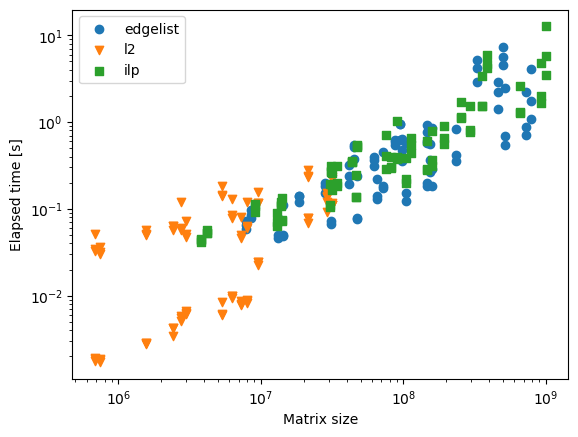

In [3]:
x = {}
y = {}
weighting_x = {}
weighting_y = {}

for filename in chain.from_iterable(Path(target_dir).glob("*.npz") for target_dir in target_dirs):
    method, _, toa, _, cross, weighting_method = filename.stem.split("_")
    data = np.load(filename)
    m_shape = data["m_shape"]
    elapsed_time = data["elapsed_time"]
    if cross == "False":
        elapsed_time = elapsed_time / 2
    x[method] = x.get(method, []) + [reduce(lambda x, y: x * y, m_shape)]
    y[method] = y.get(method, []) + [elapsed_time]
    weighting_x[weighting_method] = weighting_x.get(weighting_method, []) + [reduce(lambda x, y: x * y, m_shape)]
    weighting_y[weighting_method] = weighting_y.get(weighting_method, []) + [elapsed_time]

markers = ["o", "v", "s", "D", "P", "X", "8", "p", "*", "h", "H", "d"]

for method, marker in zip(x.keys(), markers):
    plt.scatter(x[method], y[method], label=method, marker=marker)

# for weighting_method, marker in zip(weighting_x.keys(), markers):
#     plt.scatter(weighting_x[weighting_method], weighting_y[weighting_method], label=weighting_method, marker=marker)
plt.xlabel("Matrix size")
plt.ylabel("Elapsed time [s]")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.show()

## Runtime v.s. Method

In [4]:
frame = []

for dir_path in target_dirs:
    dataset_name = dir_path.name
    runtime = {}

    for filename in dir_path.glob("*.npz"):
        method, _, toa, _, cross, weighting_method = filename.stem.split("_")
        data = np.load(filename)
        elapsed_time = data["elapsed_time"]
        runtime[method] = runtime.get(method, []) + [elapsed_time]

    frame.append(
        reduce(
            lambda x_dict, method_kv: x_dict
            | {
                f"{method_kv[0]}_min": np.min(method_kv[1]),
                f"{method_kv[0]}_max": np.max(method_kv[1]),
                f"{method_kv[0]}_mean": np.mean(method_kv[1]),
            },
            runtime.items(),
            {"dataset": dataset_name},
        )
    )

frame = pd.DataFrame(frame)
frame.sort_values(by="dataset")

,dataset,edgelist_min,edgelist_max,edgelist_mean,l2_min,l2_max,l2_mean,ilp_min,ilp_max,ilp_mean
0,AACHEN,0.246980,5.231714,1.652198,0.011930,0.371238,0.163701,0.400987,2.633523,1.040715
2,ARI,0.154054,0.935367,0.478490,0.006894,0.158391,0.071692,0.217949,1.538356,0.539918
5,CIPIC,0.134127,0.646112,0.341031,0.005507,0.130310,0.054872,0.186110,0.901232,0.414428
6,RIEC,0.097752,0.542534,0.265345,0.003425,0.073726,0.033153,0.104463,1.018068,0.281581
4,SADIE,0.366549,7.230055,2.668050,0.016500,0.240465,0.120216,0.632352,12.665768,3.559120
1,SONICOM,0.091998,0.320153,0.165687,0.003525,0.119366,0.041832,0.084002,0.395362,0.192786
3,THK,0.370482,2.857014,1.316554,0.015667,0.160136,0.098355,0.554838,4.776718,1.609298


## Compare edgelist with ilp


open SOFA file "KEMAR_Knowl_EarSim_SmallEars_FreeFieldComp_44kHz.sofa"
 --> samplerate: 44100 Hz, receivers: 2, emitters: 1, measurements: 828, samples: 256, format: float64
 --> convention: SimpleFreeFieldHRIR, version: 1.0

open SOFA file "KEMAR_Knowl_EarSim_SmallEars_FreeFieldComp_44kHz.sofa"
 --> samplerate: 44100 Hz, receivers: 2, emitters: 1, measurements: 828, samples: 256, format: float64
 --> convention: SimpleFreeFieldHRIR, version: 1.0

open SOFA file "KEMAR_Knowl_EarSim_SmallEars_FreeFieldComp_44kHz.sofa"
 --> samplerate: 44100 Hz, receivers: 2, emitters: 1, measurements: 828, samples: 256, format: float64
 --> convention: SimpleFreeFieldHRIR, version: 1.0

open SOFA file "KEMAR_Knowl_EarSim_SmallEars_FreeFieldComp_44kHz.sofa"
 --> samplerate: 44100 Hz, receivers: 2, emitters: 1, measurements: 828, samples: 256, format: float64
 --> convention: SimpleFreeFieldHRIR, version: 1.0

open SOFA file "KEMAR_Knowl_EarSim_SmallEars_FreeFieldComp_44kHz.sofa"
 --> samplerate: 44100 H

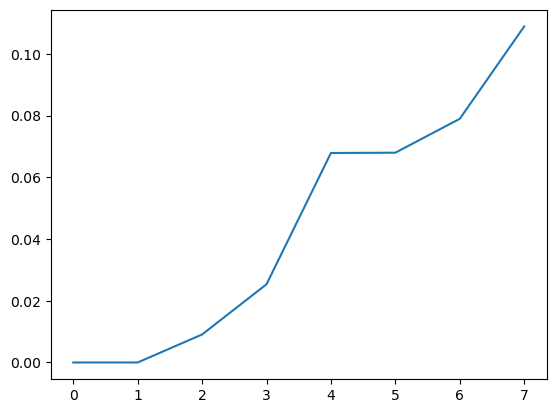

In [6]:
ilp_results = {}
edgelist_results = {}
for filename in chain.from_iterable(Path(target_dir).glob("*.npz") for target_dir in ["processed/SONICOM"]):
    method, *rest = filename.stem.split("_")
    dataset = filename.parent.name
    if method not in ("ilp", "edgelist"):
        continue
    data = np.load(filename)
    args_file = filename.parent / "args.yaml"
    args = yaml.safe_load(args_file.read_text())
    sofa = sfa.io.read_SOFA_file(args["input"])
    sr = sofa.l.fs
    k = "_".join([dataset] + rest)
    if method == "ilp":
        ilp_results[k] = data["toa"] / sr
    elif method == "edgelist":
        edgelist_results[k] = data["toa"] / sr


differences = [np.max(np.abs(ilp_results[k] - edgelist_results[k])) for k in ilp_results.keys()]

print(list(zip(ilp_results.keys(), differences)))
is_zero_mask = np.array(differences) == 0
nonzero_differences = np.array(differences)[~is_zero_mask]

print(f"Zero differences portion: {is_zero_mask.sum() / len(differences) * 100} %")
print(f"Nonzero differences: max {nonzero_differences.max() * 1000}, min {nonzero_differences.min() * 1000} (ms)")

plt.plot(np.sort(nonzero_differences) * 1000)
plt.show()

In [8]:
raw_data = []
# for dirname in filter(lambda x: x.is_dir(), Path("processed").glob("*")):
for dirname in target_dirs:
    print(dirname)
    args_file = dirname / "args.yaml"
    args = yaml.safe_load(args_file.read_text())

    hrir_data = sfa.io.read_SOFA_file(args["input"])
    sr = hrir_data.l.fs
    az = hrir_data.grid.azimuth
    col = hrir_data.grid.colatitude
    radius = hrir_data.grid.radius
    hrir_xyz = sfa.utils.sph2cart((az, col, radius)).T

    hrir = np.stack((hrir_data.l.signal, hrir_data.r.signal), axis=1)
    hrtf = np.fft.rfft(hrir, axis=2)

    for filename in dirname.glob("*.npz"):
        method, _, with_toa, _, with_cross, weighting_method = filename.stem.split("_")
        data = np.load(filename)
        # m_shape = data["m_shape"]
        # elapsed_time = data["elapsed_time"]
        toa = data["toa"]

        itd = (toa[:, 0] - toa[:, 1]) / sr
        shifts = toa - toa.min(0)
        shifter = np.exp(2j * np.pi * np.arange(hrtf.shape[-1]) / hrir.shape[-1] * shifts[..., None])
        aligned_hrir = np.fft.irfft(hrtf * shifter, axis=2)

        for N in range(2, 16):
            F_nm = sht_lstsq_reg(itd[:, None], N, az, col, "real", eps=1e-5)
            recon_itd = inverse_sht(F_nm, az, col, "real")[:, 0]

            itd_diff_us = np.abs(itd - recon_itd).mean() * 1e6

            F_nm = sht_lstsq_reg(
                aligned_hrir.reshape(aligned_hrir.shape[0], -1),
                N,
                az,
                col,
                "real",
                eps=1e-5,
            )
            recon_hrir = inverse_sht(F_nm, az, col, "real").reshape(aligned_hrir.shape)
            recon_hrtf = np.fft.rfft(recon_hrir, axis=2)

            lsd_db = lsd(recon_hrtf, hrtf).mean()

            raw_data.append(
                {
                    "dataset": dirname.name,
                    "method": method,
                    "w/toa": with_toa == "True",
                    "w/cross": with_cross == "True",
                    "weighting_method": weighting_method,
                    "N": N,
                    "itd_diff_us": itd_diff_us,
                    "lsd_db": lsd_db,
                }
            )


df = pd.DataFrame(raw_data)
print(df)

processed/AACHEN

open SOFA file "MRT01.sofa"
 --> samplerate: 44100 Hz, receivers: 2, emitters: 1, measurements: 2304, samples: 256, format: float64
 --> convention: SimpleFreeFieldHRIR, version: 1.0
processed/SONICOM

open SOFA file "KEMAR_Knowl_EarSim_SmallEars_FreeFieldComp_44kHz.sofa"
 --> samplerate: 44100 Hz, receivers: 2, emitters: 1, measurements: 828, samples: 256, format: float64
 --> convention: SimpleFreeFieldHRIR, version: 1.0
processed/ARI

open SOFA file "hrtf_nh4.sofa"
 --> samplerate: 48000 Hz, receivers: 2, emitters: 1, measurements: 1550, samples: 256, format: float64
 --> convention: SimpleFreeFieldHRIR, version: 1.0
processed/THK

open SOFA file "../hrtf-phase-unwrap/HRIR_L2702_NF100.sofa"
 --> samplerate: 48000 Hz, receivers: 2, emitters: 1, measurements: 2702, samples: 128, format: float64
 --> convention: SimpleFreeFieldHRIR, version: 1.0
 --> listener: Neumann KU100
 --> author: Johannes M. Arend
processed/SADIE

open SOFA file "H3_48K_24bit_256tap_FIR_SOFA.so

In [9]:
df.to_csv("processed/summary.csv", index=False)

In [10]:
df = pd.read_csv("processed/summary.csv")

def overN(df, dataset, N_range=range(2, 16)):
    # return df[df.loc[:, "dataset"] == dataset].drop(columns=["dataset", "N"]).groupby(["method", "w/toa", "w/cross", "weighting_method"]).mean()
    mask = (df.loc[:, "dataset"] == dataset) & (df.loc[:, "N"].isin(N_range))
    return df[mask].drop(columns=["dataset", "N"]).groupby(["method", "w/toa", "w/cross", "weighting_method"]).mean()


kemar_summary = overN(df, "ARI", range(4, 5))

In [11]:
# compare different methods
print(kemar_summary.groupby("method").agg(["mean", "median"]).sort_values(("lsd_db", "mean")))

# compare different weighting methods
print(kemar_summary.groupby("weighting_method").agg(["mean", "median"]).sort_values(("lsd_db", "mean")))

# compare w/toa and w/cross
print(kemar_summary.groupby(["w/toa", "w/cross"]).agg(["mean", "median"]).sort_values(("lsd_db", "mean")))

         itd_diff_us               lsd_db          
                mean     median      mean    median
method                                             
edgelist   17.680170  17.548806  4.082644  4.004931
ilp        17.699261  17.575405  4.083579  4.013135
l2         17.217486  17.022845  4.203151  4.268622
                 itd_diff_us               lsd_db          
                        mean     median      mean    median
weighting_method                                           
angle              17.322238  17.425081  3.896179  3.859836
dot                17.603660  17.509552  4.224334  4.345516
none               17.671019  17.550052  4.248861  4.396641
              itd_diff_us               lsd_db          
                     mean     median      mean    median
w/toa w/cross                                           
False False     17.403629  17.620198  3.872683  3.867082
      True      17.973691  17.983561  4.122288  4.106795
True  False     17.288523  17.388012  4.238

In [13]:



# print(kemar_summary.sort_values(("lsd_db")))

# pick best method for each dataset given N
best_method = df.groupby(["dataset", "N"]).apply(lambda x: x.sort_values("lsd_db").iloc[0].drop(columns=("dataset", "N"))).to_csv("processed/best_method.csv")

In [14]:
ilp_np = df[df.loc[:, "method"] == "ilp"].drop(columns=["dataset", "method", "N", "w/toa", "w/cross", "weighting_method"]).to_numpy().flatten()
ilp_np = (ilp_np - ilp_np.mean()) / ilp_np.std()

edgelist_np = df[df.loc[:, "method"] == "edgelist"].drop(columns=["dataset", "method", "N", "w/toa", "w/cross", "weighting_method"]).to_numpy().flatten()
edgelist_np = (edgelist_np - edgelist_np.mean()) / edgelist_np.std()

l2_np = df[df.loc[:, "method"] == "l2"].drop(columns=["dataset", "method", "N", "w/toa", "w/cross", "weighting_method"]).to_numpy().flatten()
l2_np = (l2_np - l2_np.mean()) / l2_np.std()

# compute correlation
print((ilp_np @ edgelist_np) / (np.linalg.norm(ilp_np) * np.linalg.norm(edgelist_np)))
print((ilp_np @ l2_np) / (np.linalg.norm(ilp_np) * np.linalg.norm(l2_np)))
print((edgelist_np @ l2_np) / (np.linalg.norm(edgelist_np) * np.linalg.norm(l2_np)))

0.987266580360484
0.9714395052586257
0.977504386910286
